# Trabalho prático II - Classificação

O objetivo deste trabalho é praticar os conceitos de aprendizado supervisionado que vimos em sala.

A sua tarefa será treinar um classificador para um conjunto de dados misterioso (se eu falasses qual é o objetivo do modelo, você encontraria soluções na Internet).

Baixe o arquivo [t2.tar.gz](https://drive.google.com/file/d/125plHKUzFGxHjjCiVJcTQG2bPG_zgDNV/view?usp=sharing). Descoprima este arquivo para encontrar outros quatro. Os arquivos `train_X.csv` e `train_y.csv` possuem os dados que você deve usar para treinar o modelo. O arquivo `test_X.csv` possui os objetos para os quais você deve encontrar as classes (testar o modelo). Por fim, o arquivo `test_example_y.csv` é um exemplo de como sua solução final deve ser organizada.

Cada linha dos arquivos `train_X.csv` e `test_X.csv` tem 15 campos descrevendo um objeto misterioso. O campo `id` representa o identificador do objeto, sendo que este campo não deve ser considerado em seu modelo. Os atributos a serem usados no modelo são os 14 campos rotulados de de `a` até `n`. Desses atributos:
- `b`, `d`, `f`, `g`, `h`, `i`, `j` e `n` são categóricos; e
- `a`, `c`, `e`, `k`, `l` e `m` são numéricos.

Cada linha do arquivo `train_y.csv` possui dois campos. O primeiro é o identificador de um objeto do arquivo `train_X.csv` e o segundo é a classe do respectivo objeto (0 ou 1).

Seu objetivo é encontrar as classes dos objetos do arquivo `test_X.csv` e mostrar como chegou em sua solução! Os dados do arquivo de teste foram obtido a partir de uma amostra aleatório do todo. Ou seja, um modelo bem treinado, e sem _overfitting_, em `train_X.csv` e `train_y.csv` se sairá bem em `test_X.csv`.

**Data de entrega:** dia 4 de julho de 2018.

**Grupo:** de até 3 pessoas, mas duas pessoas do mesmo grupo no trabalho 1 não podem pertencer ao mesmo grupo nesse trabalho.

**Valor:** 20% da nota do semestre.

Os três seguintes pontos descrevem o que obrigatoriamente deve ser entregue, com seu respectivo valor.

1 - **[10 pontos]** Este notebook com todo seu código e resultados (números, tabelas e gráficos). Você pode usar qualquer um dos métodos que estudamos ou alguma de suas variações próximas. Se estiver na dúvida se pode usar um método, basta perguntas no Piazza. Comentários e justificativas no notebook não serão considerados para sua nota.
O notebook deve ser enviado para o email do professor.

2 - **[8 pontos]** Um relatório digitado contendo: capa, introdução, metodologia, resultados, conclusão e referências. O relatório deve ter no máximo 10 páginas, com coluna simples, fonte 11, espaçamento 1.5 e margens de 2cm. A seção de metodologia deve conter uma descrição detalhada dos passos seguidos (não incluir código no relatório). A seção de resultados deve conter obrigatoriamente: uma caracterização descritiva dos dados, matriz de confusão das predições, _precision_, _recall_, _F1 score_ e acurácia. Todas as métricas de predição devem ser calculadas a partir dos arquivos de treinamento por meio de validação cruzada.
O relatório deve ser enviado para o email do professor.

3 - **[2 pontos + equivalente a lista extra pela classificação]** A sua predição final do arquivo `test_X.csv` deve ser enviada para o professor por email. O formato deve ser o mesmo do arquivo `train_y.csv`, assim como exemplificado em `test_example_y.csv` (mas repare que as classes desse último arquivo foram gerados de forma aleatória). Em outras palavras, o arquivo a ser entregue deve ter dois campos. O campo `id` é o identificador do objeto em `test_X.csv` e o campo `label` é a classe que seu modelo encontrou para o objeto em questão. A primeira linha do arquivo deve conter os nomes das colunas.
A entrega desse arquivo é obrigatória e vale dois pontos. Além disso, o trabalho com maior _F1 score_ ganhará o equivalente a 100% de uma lista extra. O trabalho com o pior _F1 score_ não ganhará nota extra alguma. Os demais trabalhos terão nota proporcional.
O professor se reserva o direito de anular esse quesito (nota extra) se houver indícios de má conduta durante a competição.

**Kaggle:** Estou tentando criar uma competição para esse trabalho na plataforma _Kaggle_. Se eu conseguir, compartilho o _link_ com você no _Piazza_.

### Bibliotecas

In [1]:
import pandas as pd
import sklearn.feature_selection as features
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals import joblib
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import tree, svm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import itertools

### Processamento dos arquivos e normalização dos dados

In [5]:
division = 40222

X = pd.concat([pd.read_csv('data/train_X.csv'),pd.read_csv('data/test_X.csv')])
X = pd.DataFrame(OneHotEncoder(categorical_features = [2,4,6,7,8,9,10,14],sparse=False).fit_transform(X))


ids = X[98]
X = X.drop(columns=[98])

for column in X:
    X[column] = (X[column] - X[column].min()) / (X[column].max() - X[column].min())
    
X.insert(loc=0, column="id", value=ids)

X.rename(inplace=True, columns={99:"a",100:"c",101:"e",102:"k",103:"l",104:"m"})

trainX = X[:division]
testX = X[division:]

trainX.to_csv("data/pd_trainX.csv", index=False)
testX.to_csv("data/pd_testX.csv", index=False)

In [9]:
X = pd.read_csv("data/pd_trainX.csv")
y = pd.read_csv("data/train_y.csv")
testX = pd.read_csv("data/pd_testX.csv")
        
X = X.drop(columns=["id"]).values
y = (y.drop(columns=["id"]).T).values[0]

In [10]:
print(X, end='\n\n')
print(y)

[[0.         0.         1.         ... 0.         0.         0.29591837]
 [0.         1.         0.         ... 0.         0.         0.37755102]
 [0.         0.         1.         ... 0.         0.         0.39795918]
 ...
 [0.         0.         1.         ... 0.         0.         0.5       ]
 [0.         0.         0.         ... 0.         0.         0.39795918]
 [1.         0.         0.         ... 0.         0.         0.39795918]]

[0 0 0 ... 1 1 1]


In [11]:
testX

,id,0,1,2,3,4,5,6,7,8,...,94,95,96,97,a,c,e,k,l,m
0,16432.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.013699,0.172301,0.400000,0.000000,0.000000,0.142857
1,11559.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.205479,0.213920,0.866667,0.000000,0.000000,0.397959
2,7714.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.410959,0.074608,0.866667,0.076881,0.000000,0.602041
3,11576.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.260274,0.127311,0.800000,0.000000,0.000000,0.397959
4,10336.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.013699,0.120268,0.400000,0.000000,0.000000,0.193878
5,11249.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.424658,0.071419,0.333333,0.000000,0.000000,0.397959
6,11030.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.136986,0.018692,0.533333,0.000000,0.000000,0.295918
7,10292.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.246575,0.062316,0.533333,0.000000,0.000000,0.397959
8,13980.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.315068,0.103136,0.600000,0.000000,0.000000,0.397959
9,5558.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.328767,0.147226,0.533333,0.000000,0.000000,0.397959


### Definição de funções

In [12]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks([])
    plt.yticks([])

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
def create_scores_df(model):
    predicted = model.predict(X_test)
    scores ={"Accuracy Score": [accuracy_score(y_test, predicted)],
            "F1 Score": [f1_score(y_test, predicted)],
            "Precision Score": [precision_score(y_test, predicted)],
            "Recall Score": [recall_score(y_test, predicted)]}

    return pd.DataFrame(data=scores)

### Divisão do conjunto de treino/teste

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [15]:
print(X_train, len(X_train), sep = '\n\n')

[[0.         0.         1.         ... 0.         0.         0.5       ]
 [0.         0.         1.         ... 0.         0.         0.29591837]
 [0.         0.         1.         ... 0.         0.58746556 0.5       ]
 ...
 [0.         0.         1.         ... 0.         0.         0.39795918]
 [0.         0.         1.         ... 0.         0.         0.39795918]
 [0.         1.         0.         ... 0.         0.         0.19387755]]

26948


In [16]:
print(X_test, len(X_test), sep = '\n\n')

[[0.         0.         1.         ... 0.         0.         0.39795918]
 [0.         0.         1.         ... 0.         0.         0.35714286]
 [0.         0.         1.         ... 0.         0.         0.39795918]
 ...
 [0.         0.         1.         ... 0.         0.         0.34693878]
 [0.         0.         0.         ... 0.         0.         0.07142857]
 [0.         1.         0.         ... 0.04386044 0.         0.44897959]]

13274


In [17]:
print(y_train, len(y_train), sep = '\n\n')

[1 0 1 ... 0 0 0]

26948


In [18]:
print(y_test, len(y_test), sep = '\n\n')

[0 0 0 ... 0 0 1]

13274


### Random Forest Classifier

#### Treino e matriz de confusão

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1 
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1 
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1 
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1 
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1 
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1 
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1 
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 

[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.0, total=   5.8s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.0, total=   5.8s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.0, total=   5.8s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.0, total=   5.8s


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.8s


[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.0, total=   6.1s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.0, total=   6.0s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.0, total=   6.6s
[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.0, total=   6.5s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=3 
[CV] min_samples_split=10, max_depth=3

/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 

[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.0, total=   6.0s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=3 


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.6s


[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.0, total=   6.4s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.0, total=   6.5s
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.0, total=   6.4s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10 
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.0, total=   6.7s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=10, max_dept

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   19.1s
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: Un

[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   5.7s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   5.9s
[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.0, total=   6.3s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10 
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   6.3s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=10, ma

/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   5.5s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1 


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   33.4s


[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   5.5s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   5.5s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 

[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.0, total=   7.6s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.0, total=   8.1s
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.0, total=   8.1s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=3 
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.0, total=   8.2s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=3,

/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.0, total=   8.3s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.0, total=   8.5s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=3 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.9s


[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.0, total=   8.9s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 

[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.0, total=   8.9s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=3, score=0.0, total=   8.6s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=3, score=0.0, total=   9.4s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=3, score=0.0, total=   9.1s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=2, max_dept

/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=3, score=0.0, total=   9.2s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=3, score=0.0, total=   9.3s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=3, score=0.0, total=  10.0s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 

[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=10, score=0.0, total=   8.5s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=3, score=0.0, total=   8.5s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=3, score=0.0, total=   8.8s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=10 


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.0min


[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=10, score=0.0, total=   8.5s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=10, score=0.0, total=   9.3s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=10, score=0.0, total=   8.1s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=10, score=0.0, total=   8.6s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=10, score=0.0, total=   9.2s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=10, score=0.0, total=   8.5s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=10, score=0.0, total=   8.4s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=10, score=0.0, total=   8.5s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=1, score=0.2873607376104495, total=  14.5s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=1 
[CV]  min_s

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.3min


[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=1, score=0.2441906262307995, total=  14.0s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=1, score=0.24318989340702724, total=  13.9s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=1, score=0.25713169206721376, total=  15.5s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=1, score=0.24823252160251377, total=  14.9s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=10, boots

[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.8min


[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=3, score=0.264797507788162, total=  15.9s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=3, score=0.26365054602184085, total=  15.8s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=3, score=0.27332559039876114, total=  15.1s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=10, score=0.29042145593869734, total=  14.5s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=

[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.5min


[CV]  min_samples_split=2, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.6465981399902105, total=  23.4s
[CV] min_samples_split=2, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.6376811594202898, total=  21.8s
[CV] min_samples_split=2, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.6556820935304095, total=  22.6s
[CV] min_samples_split=2, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.6465942744323792, total=  22.2s
[CV] min_samples_split=3, max_depth=None, criterion=gini, max_feat

/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.20786516853932585, total=  11.2s
[CV] min_samples_split=3, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=2, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   6.5s
[CV] min_samples_split=3, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10 


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.9min
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.6435267291613883, total=  20.9s
[CV] min_samples_split=10, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=2, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   6.7s
[CV] min_samples_split=10, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.19975737970076826, total=  11.2s
[CV] min_samples_split=10, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=2, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   6.8s
[CV] min_samples_split=2, max_depth=None, criterion=gini, max_features=3, bootstrap=T

/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.22319301032565528, total=  11.9s
[CV] min_samples_split=2, max_depth=None, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   7.1s
[CV] min_samples_split=2, max_depth=None, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   6.8s
[CV] min_samples_split=3, max_depth=None, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   7.0s


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] min_samples_split=3, max_depth=None, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   6.9s
[CV] min_samples_split=3, max_depth=None, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   6.6s
[CV] min_samples_split=10, max_depth=None, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   7.0s
[CV] min_samples_split=10, max_depth=None, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=None, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.6528724440116845, total=  24.2s
[CV] min_samples_split=10, max_depth=None, criterion=gini, max_features=3, bootstrap=True, min_samples_

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.5min


[CV] min_samples_split=3, max_depth=None, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=None, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.6535141800246609, total=  23.6s
[CV] min_samples_split=3, max_depth=None, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.6638018200202225, total=  22.6s
[CV] min_samples_split=3, max_depth=None, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=None, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.6475490196078433, total=  24.7s
[CV] min_samples_split=10, max_depth=None, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=None, criterion=gini, max_features=3, bootstrap=True, min_samples_le

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  4.1min


[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=3, score=0.5829343846803717, total=  15.5s
[CV] min_samples_split=2, max_depth=None, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=3, max_depth=None, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=10, score=0.4865565273728539, total=  14.6s
[CV] min_samples_split=3, max_depth=None, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=3, max_depth=None, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=10, score=0.49573729081149354, total=  14.6s
[CV] min_samples_split=3, max_depth=None, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=3, bootstrap=True, min_samples_leaf=10, score=0.49857459613557176, total=  12.5s
[CV] min_samples_split=3, max_depth=None, criterion=gini

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.3min


[CV]  min_samples_split=3, max_depth=None, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=3, score=0.6759651307596514, total=  27.2s
[CV] min_samples_split=2, max_depth=None, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=3, max_depth=None, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=3, score=0.6736465781409602, total=  26.3s
[CV] min_samples_split=2, max_depth=None, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=1, score=0.6745329400196657, total=  32.1s
[CV] min_samples_split=3, max_depth=None, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=3, max_depth=None, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=3, score=0.6739835370416563, total=  29.2s
[CV] min_samples_split=3, max_depth=None, criterion=gin

/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.0, total=   6.0s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.0, total=   6.0s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.0, total=   6.1s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=None, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=10, score=0.6653133722405481, total=  30.2s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.0, total=   6.0s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.0, total=   5.6s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.0, total=   6.0s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3 


[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  6.2min


[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.0, total=   6.2s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.0, total=   6.4s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.0, total=   6.4s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.0, total=   6.4s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.0, total=   6.5s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.0, total=   6.0s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=10, score=0.6728877679697352, total=  29.0s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.0, total=   6.1s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.0, total=   6.2s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=10, score=0.6578478758585602, total=  30.1s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.0, total=   6.3s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=10, bootstrap=True, min_samples_leaf=10, score=0.6638982610952504, total=  32.3s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.0, total=   6.2s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.0, total=   6.3s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   5.7s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   6.1s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.0, total=   6.5s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   5.9s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   5.9s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1 


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.5min
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: Un

[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   5.6s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   5.7s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   5.8s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   5.5s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   6.2s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.0, total=   8.1s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.0, total=   8.4s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.0, total=   8.2s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.0, total=   8.3s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.0, total=   8.6s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.0, total=   8.4s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.0, total=   8.9s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.0, total=   9.2s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.0, total=   8.6s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=3, score=0.0, total=   8.2s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=3, score=0.0, total=   9.1s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=3, score=0.0, total=   8.1s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=3, score=0.0, total=   9.1s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=3, score=0.0, total=   8.5s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=3, score=0.0, total=   8.5s


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=3, score=0.0, total=   9.5s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=10 


[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  7.0min


[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=3, score=0.0, total=   8.2s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=3, score=0.0, total=   8.8s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=10, score=0.0, total=   8.3s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 

[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=10, score=0.0, total=   8.8s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=10, score=0.0, total=   8.3s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=10, score=0.0, total=   9.4s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=10, score=0.0, total=   8.9s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=10, score=0.0, total=   8.7s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=10, score=0.0, total=   8.5s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=10, score=0.0, total=   8.5s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=10, score=0.0, total=   8.4s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=1, score=0.2656797818465135, total=  14.7s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=1, score=0.2107803700724055, total=  15.0s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=10, bootstrap

[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:  7.7min


[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=3, score=0.21482965931863726, total=  15.9s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=3, score=0.2768754833720031, total=  15.6s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=3, score=0.2529457973291438, total=  15.2s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=3, score=0.2717391304347826, total=  14.2s
[CV] min_samples_split=3, max_depth=3, criterion=entro

[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:  8.6min


[CV]  min_samples_split=10, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.6531027466937945, total=  20.0s
[CV] min_samples_split=3, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=1, score=0.6389301634472512, total=  23.7s
[CV] min_samples_split=10, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.2686798296554394, total=   9.4s
[CV] min_samples_split=10, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.18811074918566775, total=   9.5s
[CV] min_samples_split=10, max_depth=None

/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.20145044319097505, total=   9.8s
[CV] min_samples_split=3, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=2, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   6.7s
[CV] min_samples_split=3, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.18315018315018314, total=  10.4s
[CV] min_samples_split=3, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=2, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   6.7s
[CV] min_samples_split=10, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=10, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.21107544141252008, total=  10.4s
[CV] min_samples_split=10, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10 
[CV]  min_samples_split=10, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=3, score=0.20570510245078344, total=  10.4s
[CV] min_samples_split=10, max_depth=None, crite

/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   6.8s
[CV] min_samples_split=2, max_depth=None, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=3, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   6.8s
[CV] min_samples_split=2, max_depth=None, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   6.6s
[CV] min_samples_split=3, max_depth=None, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   6.2s
[CV] min_samples_split=3, max_depth=None, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   6.3s
[CV] min_samples_split=3, max_depth=None, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   6.6s
[CV] min_samples_split=10, max_depth=None, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=None, criterion=entropy, max_features=1, bootstrap=True, min_samples_leaf=10, score=0.0, total=   6.7s
[CV] min_samples_split=10, max_depth=None, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=None, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.6617189370361504, total=  26.0s
[CV] min_samples_split=10, max_depth=None, criterion=entropy, max_features=3, boot

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  9.5min


[CV] min_samples_split=2, max_depth=None, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=10, max_depth=None, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.6691748181590168, total=  22.6s
[CV] min_samples_split=3, max_depth=None, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=None, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.6679435001197032, total=  25.7s
[CV] min_samples_split=3, max_depth=None, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=None, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=1, score=0.6602941176470588, total=  25.3s
[CV] min_samples_split=3, max_depth=None, criterion=entropy, max_features=3, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=None, criterion=entropy, max_features=3, bootstr

[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed: 10.3min


[CV]  min_samples_split=2, max_depth=None, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=1, score=0.6715709539629806, total=  34.0s
[CV] min_samples_split=10, max_depth=None, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=None, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=1, score=0.6708799222168206, total=  34.5s
[CV] min_samples_split=2, max_depth=None, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=None, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=1, score=0.6744630071599045, total=  35.2s
[CV] min_samples_split=2, max_depth=None, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=None, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=1, score=0.6735143066764488, total=  32.4s
[CV] min_samples_split=2, max_depth=N

/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=None, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=10, score=0.6612945152066546, total=  29.4s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.0, total=   6.2s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.0, total=   6.2s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=1 


[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed: 12.0min


[CV]  min_samples_split=3, max_depth=None, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=10, score=0.6602287166454892, total=  30.7s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.0, total=   5.9s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.0, total=   6.4s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.0, total=   6.2s
[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.0, total=   5.8s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=3 
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.0, total=   6.1s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.0, total=   6.0s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=3, score=0.0, total=   5.7s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=3, score=0.0, total=   5.8s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.0, total=   5.9s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=None, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=10, score=0.6722348772462667, total=  29.7s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=3, score=0.0, total=   6.5s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=3, score=0.0, total=   5.9s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=None, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=10, score=0.6642449403217436, total=  32.2s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=10, max_depth=None, criterion=entropy, max_features=10, bootstrap=True, min_samples_leaf=10, score=0.6634639696586598, total=  30.1s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=3, score=0.0, total=   6.5s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=3, score=0.0, total=   6.6s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=3, score=0.0, total=   6.4s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=3, score=0.0, total=   6.6s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=1

/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   6.0s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 

[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   5.7s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   5.8s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   5.8s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   6.0s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   5.8s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   6.3s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   6.6s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1 


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 12.6min
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   6.0s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 

[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.0, total=   9.1s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.0, total=   8.7s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.0, total=   9.2s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.0, total=   9.4s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.0, total=   9.5s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.0, total=   9.7s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=10, max_

/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.0, total=   9.6s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 

[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=3, score=0.0, total=   8.8s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.0, total=   9.1s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=3, score=0.0, total=   9.3s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=3, score=0.0, total=   9.2s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=3, score=0.0, total=   9.7s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=3, score=0.0, total=   9.3s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=3, m

/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=3, score=0.0, total=   9.6s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 

[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=3, score=0.0, total=   8.8s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=3, score=0.0, total=   9.0s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=10, score=0.0, total=   9.3s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=10, score=0.0, total=   9.2s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=10, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=10, score=0.0, total=   9.4s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=10, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=10, score=0.0, total=   9.5s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=10, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split

/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=10, score=0.0, total=   9.6s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=10, bootstrap=False, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=10, score=0.0, total=   8.6s
[CV] min_samples_split=3, max_depth=3, criterion=gini, max_features=10, bootstrap=False, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed: 13.3min


[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=10, score=0.0, total=   9.3s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=10, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=3, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=10, score=0.0, total=   9.3s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=10, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=10, bootstrap=False, min_samples_leaf=1, score=0.2899884925201381, total=  18.1s
[CV] min_samples_split=10, max_depth=3, criterion=gini, max_features=10, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=3, criterion=gini, max_features=10, bootstrap=False, min_samples_leaf=1, score=0.2529457973291438, total=  19.3s
[CV] min_samples_split=2, max_depth=3, criterion=gini, max_features=10, bootstrap=False, min_sampl

[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed: 14.5min


[CV]  min_samples_split=2, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.6429080541696365, total=  33.2s
[CV] min_samples_split=10, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.6361457334611696, total=  31.9s
[CV] min_samples_split=2, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.6282950423216446, total=  30.0s
[CV] min_samples_split=2, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.6565260058881256, total=  23.8s
[CV] min_samples_split=2, max_depth=None, criterion=gini,

/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   7.7s
[CV] min_samples_split=3, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   8.2s
[CV] min_samples_split=10, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=3, score=0.36540540540540534, total=  14.4s
[CV] min_samples_split=10, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=2, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   8.0s
[CV] min_samples_split=10, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.6400399400898653, total=  29.6s
[CV] min_samples_split=2, max_depth=None, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=3, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   9.1s
[CV] min_samples_split=2, max_depth=None, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=3, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   8.6s
[CV] min_samples_split=2, max_depth=None, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=3, score=0.37393162393162394, total=  15.1s
[CV] min_samples_split=3, max_depth=None, criterion=gini, max_features=3, bootstrap=

/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   8.1s
[CV] min_samples_split=3, max_depth=None, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   7.9s
[CV] min_samples_split=3, max_depth=None, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   8.3s
[CV] min_samples_split=10, max_depth=None, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   7.8s
[CV] min_samples_split=10, max_depth=None, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=None, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.6501650165016502, total=  34.8s
[CV] min_samples_split=10, max_depth=None, criterion=gini, max_features=3, bootstrap=False, min_

[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 16.1min


[CV]  min_samples_split=3, max_depth=None, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.6526114039290849, total=  30.8s
[CV] min_samples_split=2, max_depth=None, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=None, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.6368421052631578, total=  34.9s
[CV] min_samples_split=2, max_depth=None, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.6684466019417475, total=  28.8s
[CV] min_samples_split=3, max_depth=None, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=None, criterion=gini, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.6544763714082166, total=  34.5s
[CV] min_samples_split=3, max_depth=None, criterion=gini, 

[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed: 18.1min


[CV]  min_samples_split=3, max_depth=None, criterion=gini, max_features=10, bootstrap=False, min_samples_leaf=1, score=0.656867469879518, total=  45.4s
[CV] min_samples_split=3, max_depth=None, criterion=gini, max_features=10, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=10, bootstrap=False, min_samples_leaf=1, score=0.6766658470617163, total=  47.8s
[CV] min_samples_split=10, max_depth=None, criterion=gini, max_features=10, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=None, criterion=gini, max_features=10, bootstrap=False, min_samples_leaf=3, score=0.6760633036597429, total=  38.7s
[CV] min_samples_split=10, max_depth=None, criterion=gini, max_features=10, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=10, bootstrap=False, min_samples_leaf=1, score=0.6710526315789473, total=  44.1s
[CV] min_samples_split=10, max_depth=None, criter

/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.0, total=   5.3s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.0, total=   5.6s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.0, total=   5.9s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=None, criterion=gini, max_features=10, bootstrap=False, min_samples_leaf=10, score=0.6666666666666667, total=  44.8s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=3, max_depth=None, criterion=gini, max_features=10, bootstrap=False, min_samples_leaf=10, score=0.6678418534374213, total=  39.7s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.0, total=   5.8s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.0, total=   6.0s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.0, total=   6.2s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.0, total=   5.8s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.0, total=   6.2s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=1, score=0.0, total=   6.3s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=3, score=0.0, total=   6.4s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=3, score=0.0, total=   6.1s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=3, score=0.0, total=   5.8s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=3, score=0.0, total=   6.0s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=3 


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 20.0min
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=3, score=0.0, total=   6.1s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=3, score=0.0, total=   6.2s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=3, score=0.0, total=   6.3s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=3, score=0.0, total=   6.0s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=10, bootstrap=False, min_samples_leaf=10, score=0.6740498363956708, total=  44.7s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=3, score=0.0, total=   6.2s


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   6.0s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   5.9s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   5.6s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   5.5s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   5.7s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=10, bootstrap=False, min_samples_leaf=10, score=0.6697554697554697, total=  44.8s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   6.0s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   6.1s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   6.3s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   5.6s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=None, criterion=gini, max_features=10, bootstrap=False, min_samples_leaf=10, score=0.6678418534374213, total=  49.0s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 

[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.0, total=   8.9s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.0, total=   8.7s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.0, total=   9.3s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.0, total=   9.3s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.0, total=   8.9s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=3 
[CV]  mi

/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.0, total=   9.3s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.0, total=   9.1s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.0, total=   9.0s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=3 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=3, score=0.0, total=   9.1s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=3, score=0.0, total=   9.3s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=3, score=0.0, total=   9.8s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=3, score=0.0, total=   9.7s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=10 
[CV]

/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=3, score=0.0, total=   9.1s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=3, score=0.0, total=   9.2s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=10 


[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed: 20.7min
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=3, score=0.0, total=   9.1s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=3, score=0.0, total=   8.7s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=10, score=0.0, total=   9.1s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=10, score=0.0, total=   9.6s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=10, score=0.0, total=   9.7s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=10, score=0.0, total=   9.5s
[CV] min_samples_split=2, max_depth=3, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=1 

/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=10, score=0.0, total=   9.3s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=10, score=0.0, total=   9.3s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=10, score=0.0, total=   9.1s
[CV] min_samples_split=3, max_depth=3, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=10, score=0.0, total=   8.7s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=10, score=0.0, total=   9.3s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=2, max_depth=3, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=1, score=0.25146427176884034, total=  18.5s
[CV] min_samples_split=10, max_depth=3, criterion=entropy, max_features=10, bootstrap=False

[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed: 22.1min


[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=10, score=0.2107803700724055, total=  20.2s
[CV] min_samples_split=3, max_depth=None, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=3, max_depth=3, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=10, score=0.2474469756480754, total=  19.3s
[CV] min_samples_split=3, max_depth=None, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=10, score=0.26692607003891056, total=  15.9s
[CV] min_samples_split=3, max_depth=None, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=3, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=10, score=0.24428684003152087, total=  15.8s
[CV] min_samples_split=10, max_depth=N

/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=2, max_depth=None, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   8.4s
[CV] min_samples_split=3, max_depth=None, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=2, max_depth=None, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   8.0s
[CV] min_samples_split=10, max_depth=None, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=2, max_depth=None, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   8.0s
[CV] min_samples_split=10, max_depth=None, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=None, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=3, score=0.39901477832512317, total=  15.1s
[CV] min_samples_split=10, max_depth=None, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=10, max_depth=None, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=3, score=0.39944134078212284, total=  15.1s
[CV] min_samples_split=2, max_depth=None, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=3, max_depth=None, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   8.4s
[CV] min_samples_split=2, max_depth=None, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=3, max_depth=None, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   8.5s
[CV] min_samples_split=2, max_depth=None, criterion=entropy,

/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=3, max_depth=None, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   7.9s
[CV] min_samples_split=3, max_depth=None, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=None, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   8.0s
[CV] min_samples_split=3, max_depth=None, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=None, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   8.1s
[CV] min_samples_split=10, max_depth=None, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1 


/home/gaabrielfranco/Documents/github/data-mining-w2/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  min_samples_split=10, max_depth=None, criterion=entropy, max_features=1, bootstrap=False, min_samples_leaf=10, score=0.0, total=   7.2s
[CV] min_samples_split=10, max_depth=None, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=3, max_depth=None, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.6554182509505703, total=  36.4s
[CV] min_samples_split=10, max_depth=None, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1 
[CV]  min_samples_split=10, max_depth=None, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.6686060606060606, total=  32.9s
[CV] min_samples_split=2, max_depth=None, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=None, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.6461611826418694, total=  38.7s
[CV] min_samples_split=2, max_depth=None, criter

[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed: 24.0min


[CV]  min_samples_split=2, max_depth=None, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.6512832587708971, total=  40.6s
[CV] min_samples_split=2, max_depth=None, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=10, max_depth=None, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.6663373672511732, total=  33.3s
[CV] min_samples_split=3, max_depth=None, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=None, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.6369944962909787, total=  40.3s
[CV] min_samples_split=3, max_depth=None, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=None, criterion=entropy, max_features=3, bootstrap=False, min_samples_leaf=1, score=0.6401350699469368, total=  36.0s
[CV] min_samples_split=3, max_depth=N

[CV] min_samples_split=3, max_depth=None, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=3, max_depth=None, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=1, score=0.6570535928863255, total=  51.5s
[CV] min_samples_split=10, max_depth=None, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=None, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=3, score=0.6762092793682134, total=  42.6s
[CV] min_samples_split=10, max_depth=None, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=2, max_depth=None, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=3, score=0.6753114670734809, total=  46.1s
[CV] min_samples_split=10, max_depth=None, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=3 
[CV]  min_samples_split=10, max_depth=None, criterion=entropy, max_fe

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 26.7min


[CV]  min_samples_split=2, max_depth=None, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=3, score=0.6761194029850747, total=  46.8s
[CV] min_samples_split=2, max_depth=None, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=3, max_depth=None, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=3, score=0.677180877279448, total=  43.5s
[CV] min_samples_split=2, max_depth=None, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=3, max_depth=None, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=3, score=0.6766955634880163, total=  44.2s
[CV] min_samples_split=3, max_depth=None, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=10 
[CV]  min_samples_split=10, max_depth=None, criterion=entropy, max_features=10, bootstrap=False, min_samples_leaf=3, score=0.6775308641975308, total=  43.6s
[CV] min_samples_split=3, ma

[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 27.9min finished


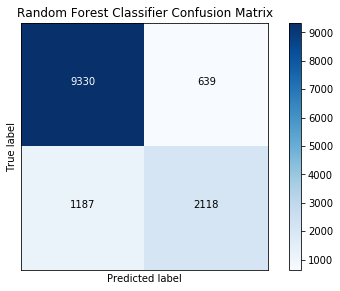

In [22]:
#params_rfc = {'n_estimators': list(range(100, 2000, 100))}
from scipy.stats import randint as sp_randint
params_rfc = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

rfc = GridSearchCV(RandomForestClassifier(n_estimators=500), params_rfc, "f1", n_jobs=-1, verbose = 10) 
rfc.fit(X_train, y_train)

plot_confusion_matrix(confusion_matrix(y_test, rfc.predict(X_test)), title="Random Forest Classifier Confusion Matrix")

#### Melhor estimador

In [27]:
rfc.best_estimator_
#joblib.dump(rfc.best_estimator_, 'models/test_rfc.pkl') 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Tabela de scores

In [25]:
df_scores_rfc = create_scores_df(rfc)
df_scores_rfc

,Accuracy Score,F1 Score,Precision Score,Recall Score
0,0.862438,0.698779,0.768226,0.640847


In [31]:
predicted_X = rfc.predict(testX.drop(columns=["id"]))
predicted_X

array([0, 0, 1, ..., 0, 0, 0])

In [32]:
testX_values = testX["id"].values
df_predicted = pd.DataFrame(predicted_X, columns=["label"])
df_predicted.insert(0, "id", [int(i) for i in testX_values])
df_predicted.to_csv("data/prediction_random_forest_2_best.csv", index=False)
df_predicted

,id,label
0,16432,0
1,11559,0
2,7714,1
3,11576,1
4,10336,0
5,11249,0
6,11030,0
7,10292,0
8,13980,0
9,5558,0


#### Aumentando um pouco mais o número de estimadores

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] min_samples_leaf=1, max_depth=None, n_estimators=1000, min_samples_split=10, max_features=10, bootstrap=True 
[CV] min_samples_leaf=1, max_depth=None, n_estimators=1000, min_samples_split=10, max_features=10, bootstrap=True 
[CV] min_samples_leaf=1, max_depth=None, n_estimators=1000, min_samples_split=10, max_features=10, bootstrap=True 
[CV] min_samples_leaf=1, max_depth=None, n_estimators=1500, min_samples_split=10, max_features=10, bootstrap=True 
[CV] min_samples_leaf=1, max_depth=None, n_estimators=1500, min_samples_split=10, max_features=10, bootstrap=True 
[CV] min_samples_leaf=1, max_depth=None, n_estimators=1500, min_samples_split=10, max_features=10, bootstrap=True 
[CV] min_samples_leaf=1, max_depth=None, n_estimators=2000, min_samples_split=10, max_features=10, bootstrap=True 
[CV] min_samples_leaf=1, max_depth=None, n_estimators=2000, min_samples_split=10, max_features=10, bootstrap=True 
[CV]  min_samples_

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.0min


[CV]  min_samples_leaf=1, max_depth=None, n_estimators=1000, min_samples_split=10, max_features=10, bootstrap=True, score=0.6827329192546584, total=  56.4s
[CV] min_samples_leaf=1, max_depth=None, n_estimators=2500, min_samples_split=10, max_features=10, bootstrap=True 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=1500, min_samples_split=10, max_features=10, bootstrap=True, score=0.6773241515002459, total= 1.4min
[CV] min_samples_leaf=1, max_depth=None, n_estimators=2500, min_samples_split=10, max_features=10, bootstrap=True 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=1500, min_samples_split=10, max_features=10, bootstrap=True, score=0.6817391304347827, total= 1.4min
[CV] min_samples_leaf=1, max_depth=None, n_estimators=1000, min_samples_split=15, max_features=10, bootstrap=True 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=1500, min_samples_split=10, max_features=10, bootstrap=True, score=0.6801068739373329, total= 1.4min
[CV] min_samples_leaf=1, max_de

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.6min


[CV]  min_samples_leaf=1, max_depth=None, n_estimators=1000, min_samples_split=15, max_features=10, bootstrap=True, score=0.6829149402875945, total=  58.6s
[CV] min_samples_leaf=1, max_depth=None, n_estimators=1500, min_samples_split=15, max_features=10, bootstrap=True 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=1000, min_samples_split=15, max_features=10, bootstrap=True, score=0.6778407690411634, total=  54.4s
[CV] min_samples_leaf=1, max_depth=None, n_estimators=2000, min_samples_split=15, max_features=10, bootstrap=True 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=2000, min_samples_split=10, max_features=10, bootstrap=True, score=0.6768397735663303, total= 1.9min
[CV] min_samples_leaf=1, max_depth=None, n_estimators=2000, min_samples_split=15, max_features=10, bootstrap=True 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=2500, min_samples_split=10, max_features=10, bootstrap=True, score=0.681592039800995, total= 2.3min
[CV] min_samples_leaf=1, max_dep

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.1min


[CV]  min_samples_leaf=1, max_depth=None, n_estimators=2500, min_samples_split=10, max_features=10, bootstrap=True, score=0.6761811023622047, total= 2.4min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=1000, min_samples_split=10, max_features=10, bootstrap=True 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=1500, min_samples_split=15, max_features=10, bootstrap=True, score=0.6763475264582821, total= 1.5min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=1000, min_samples_split=10, max_features=10, bootstrap=True 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=2000, min_samples_split=15, max_features=10, bootstrap=True, score=0.6816704176044012, total= 1.9min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=1000, min_samples_split=10, max_features=10, bootstrap=True 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=2000, min_samples_split=15, max_features=10, bootstrap=True, score=0.6820724884456336, total= 1.9min
[CV] min_samples_leaf=3, max_de

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.3min


[CV]  min_samples_leaf=3, max_depth=None, n_estimators=1500, min_samples_split=10, max_features=10, bootstrap=True, score=0.6747645017352504, total= 1.3min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=2500, min_samples_split=10, max_features=10, bootstrap=True 
[CV]  min_samples_leaf=3, max_depth=None, n_estimators=1500, min_samples_split=10, max_features=10, bootstrap=True, score=0.6734902763561924, total= 1.3min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=2500, min_samples_split=10, max_features=10, bootstrap=True 
[CV]  min_samples_leaf=3, max_depth=None, n_estimators=1500, min_samples_split=10, max_features=10, bootstrap=True, score=0.6753507014028056, total= 1.3min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=1000, min_samples_split=15, max_features=10, bootstrap=True 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=2500, min_samples_split=15, max_features=10, bootstrap=True, score=0.6775308641975308, total= 2.3min
[CV] min_samples_leaf=3, max_de

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.0min


[CV]  min_samples_leaf=3, max_depth=None, n_estimators=2000, min_samples_split=10, max_features=10, bootstrap=True, score=0.6754801696183587, total= 1.7min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=2000, min_samples_split=15, max_features=10, bootstrap=True 
[CV]  min_samples_leaf=3, max_depth=None, n_estimators=1000, min_samples_split=15, max_features=10, bootstrap=True, score=0.6779915063702224, total=  54.9s
[CV] min_samples_leaf=3, max_depth=None, n_estimators=2000, min_samples_split=15, max_features=10, bootstrap=True 
[CV]  min_samples_leaf=3, max_depth=None, n_estimators=2500, min_samples_split=10, max_features=10, bootstrap=True, score=0.675427721299281, total= 2.2min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=2000, min_samples_split=15, max_features=10, bootstrap=True 
[CV]  min_samples_leaf=3, max_depth=None, n_estimators=2500, min_samples_split=10, max_features=10, bootstrap=True, score=0.6753379239989797, total= 2.2min
[CV] min_samples_leaf=3, max_dep

[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 10.7min


[CV]  min_samples_leaf=1, max_depth=None, n_estimators=1000, min_samples_split=10, max_features=15, bootstrap=True, score=0.682773616815656, total= 1.4min
[CV] min_samples_leaf=1, max_depth=None, n_estimators=1500, min_samples_split=10, max_features=15, bootstrap=True 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=1000, min_samples_split=10, max_features=15, bootstrap=True, score=0.685728493286922, total= 1.2min
[CV] min_samples_leaf=1, max_depth=None, n_estimators=2000, min_samples_split=10, max_features=15, bootstrap=True 
[CV]  min_samples_leaf=3, max_depth=None, n_estimators=2500, min_samples_split=15, max_features=10, bootstrap=True, score=0.674937965260546, total= 2.1min
[CV] min_samples_leaf=1, max_depth=None, n_estimators=2000, min_samples_split=10, max_features=15, bootstrap=True 
[CV]  min_samples_leaf=3, max_depth=None, n_estimators=2500, min_samples_split=15, max_features=10, bootstrap=True, score=0.6750127746550842, total= 2.4min
[CV] min_samples_leaf=1, max_depth

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 14.3min


[CV]  min_samples_leaf=1, max_depth=None, n_estimators=2000, min_samples_split=10, max_features=15, bootstrap=True, score=0.6824408468244085, total= 2.6min
[CV] min_samples_leaf=1, max_depth=None, n_estimators=1500, min_samples_split=15, max_features=15, bootstrap=True 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=1000, min_samples_split=15, max_features=15, bootstrap=True, score=0.6803916645744414, total= 1.3min
[CV] min_samples_leaf=1, max_depth=None, n_estimators=1500, min_samples_split=15, max_features=15, bootstrap=True 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=2000, min_samples_split=10, max_features=15, bootstrap=True, score=0.6779827798277983, total= 2.6min
[CV] min_samples_leaf=1, max_depth=None, n_estimators=2000, min_samples_split=15, max_features=15, bootstrap=True 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=1000, min_samples_split=15, max_features=15, bootstrap=True, score=0.6829388560157792, total= 1.1min
[CV] min_samples_leaf=1, max_de

[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 17.6min


[CV]  min_samples_leaf=3, max_depth=None, n_estimators=1000, min_samples_split=10, max_features=15, bootstrap=True, score=0.6772888214466364, total= 1.2min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=1500, min_samples_split=10, max_features=15, bootstrap=True 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=2000, min_samples_split=15, max_features=15, bootstrap=True, score=0.6823876197494474, total= 2.5min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=2000, min_samples_split=10, max_features=15, bootstrap=True 
[CV]  min_samples_leaf=3, max_depth=None, n_estimators=1000, min_samples_split=10, max_features=15, bootstrap=True, score=0.6785980611483967, total= 1.1min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=2000, min_samples_split=10, max_features=15, bootstrap=True 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=2500, min_samples_split=15, max_features=15, bootstrap=True, score=0.684274291252726, total= 3.2min
[CV] min_samples_leaf=3, max_dep

[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 21.1min


[CV]  min_samples_leaf=3, max_depth=None, n_estimators=2000, min_samples_split=10, max_features=15, bootstrap=True, score=0.6791230692575985, total= 2.4min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=2000, min_samples_split=15, max_features=15, bootstrap=True 
[CV]  min_samples_leaf=3, max_depth=None, n_estimators=1000, min_samples_split=15, max_features=15, bootstrap=True, score=0.6777805424234884, total= 1.2min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=2000, min_samples_split=15, max_features=15, bootstrap=True 
[CV]  min_samples_leaf=3, max_depth=None, n_estimators=2500, min_samples_split=10, max_features=15, bootstrap=True, score=0.682410824108241, total= 2.7min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=2000, min_samples_split=15, max_features=15, bootstrap=True 
[CV]  min_samples_leaf=3, max_depth=None, n_estimators=2500, min_samples_split=10, max_features=15, bootstrap=True, score=0.680458624127617, total= 2.7min
[CV] min_samples_leaf=3, max_dept

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 25.8min


[CV]  min_samples_leaf=3, max_depth=None, n_estimators=2500, min_samples_split=15, max_features=15, bootstrap=True, score=0.6768060836501901, total= 3.0min
[CV] min_samples_leaf=1, max_depth=None, n_estimators=2500, min_samples_split=10, max_features=10, bootstrap=False 
[CV]  min_samples_leaf=3, max_depth=None, n_estimators=2500, min_samples_split=15, max_features=15, bootstrap=True, score=0.6804483188044832, total= 3.1min
[CV] min_samples_leaf=1, max_depth=None, n_estimators=2500, min_samples_split=10, max_features=10, bootstrap=False 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=1500, min_samples_split=10, max_features=10, bootstrap=False, score=0.6781279847182426, total= 2.2min
[CV] min_samples_leaf=1, max_depth=None, n_estimators=2500, min_samples_split=10, max_features=10, bootstrap=False 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=1500, min_samples_split=10, max_features=10, bootstrap=False, score=0.6778325123152709, total= 2.4min
[CV] min_samples_leaf=1, m

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 31.6min


[CV]  min_samples_leaf=1, max_depth=None, n_estimators=1500, min_samples_split=15, max_features=10, bootstrap=False, score=0.678055822906641, total= 2.3min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=1000, min_samples_split=10, max_features=10, bootstrap=False 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=1500, min_samples_split=15, max_features=10, bootstrap=False, score=0.6754901960784314, total= 2.4min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=1000, min_samples_split=10, max_features=10, bootstrap=False 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=2000, min_samples_split=15, max_features=10, bootstrap=False, score=0.6788461538461538, total= 3.2min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=1000, min_samples_split=10, max_features=10, bootstrap=False 
[CV]  min_samples_leaf=3, max_depth=None, n_estimators=1000, min_samples_split=10, max_features=10, bootstrap=False, score=0.6749072929542645, total= 1.5min
[CV] min_samples_leaf=3, 

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 37.3min


[CV]  min_samples_leaf=3, max_depth=None, n_estimators=1000, min_samples_split=15, max_features=10, bootstrap=False, score=0.6727735368956742, total= 1.4min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=1500, min_samples_split=15, max_features=10, bootstrap=False 
[CV]  min_samples_leaf=3, max_depth=None, n_estimators=2000, min_samples_split=10, max_features=10, bootstrap=False, score=0.6779240129128383, total= 3.0min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=2000, min_samples_split=15, max_features=10, bootstrap=False 
[CV]  min_samples_leaf=3, max_depth=None, n_estimators=1000, min_samples_split=15, max_features=10, bootstrap=False, score=0.6779492284718764, total= 1.5min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=2000, min_samples_split=15, max_features=10, bootstrap=False 
[CV]  min_samples_leaf=3, max_depth=None, n_estimators=2500, min_samples_split=10, max_features=10, bootstrap=False, score=0.6776037782749194, total= 3.2min
[CV] min_samples_leaf=3,

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 43.3min


[CV]  min_samples_leaf=1, max_depth=None, n_estimators=1000, min_samples_split=10, max_features=15, bootstrap=False, score=0.6744412050534498, total= 2.2min
[CV] min_samples_leaf=1, max_depth=None, n_estimators=2500, min_samples_split=10, max_features=15, bootstrap=False 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=1500, min_samples_split=10, max_features=15, bootstrap=False, score=0.6770140428677014, total= 2.7min
[CV] min_samples_leaf=1, max_depth=None, n_estimators=2500, min_samples_split=10, max_features=15, bootstrap=False 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=1500, min_samples_split=10, max_features=15, bootstrap=False, score=0.6765267175572519, total= 3.3min
[CV] min_samples_leaf=1, max_depth=None, n_estimators=1000, min_samples_split=15, max_features=15, bootstrap=False 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=1500, min_samples_split=10, max_features=15, bootstrap=False, score=0.673955296404276, total= 3.1min
[CV] min_samples_leaf=1, 

[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 52.7min


[CV]  min_samples_leaf=3, max_depth=None, n_estimators=1000, min_samples_split=10, max_features=15, bootstrap=False, score=0.6777609682299546, total= 1.8min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=1500, min_samples_split=10, max_features=15, bootstrap=False 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=2000, min_samples_split=15, max_features=15, bootstrap=False, score=0.6770960645318993, total= 4.1min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=2000, min_samples_split=10, max_features=15, bootstrap=False 
[CV]  min_samples_leaf=3, max_depth=None, n_estimators=1000, min_samples_split=10, max_features=15, bootstrap=False, score=0.6830235439900868, total= 1.8min
[CV] min_samples_leaf=3, max_depth=None, n_estimators=2000, min_samples_split=10, max_features=15, bootstrap=False 
[CV]  min_samples_leaf=1, max_depth=None, n_estimators=2500, min_samples_split=15, max_features=15, bootstrap=False, score=0.6828302820385947, total= 4.5min
[CV] min_samples_leaf=3,

[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 63.8min finished


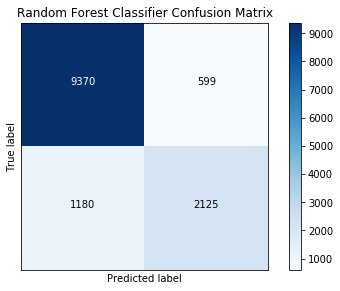

In [33]:
params_rfc = {}
from scipy.stats import randint as sp_randint
params_rfc = {'n_estimators': [1000, 1500, 2000, 2500],
              "max_depth": [None],
              "max_features": [10, 15],
              "min_samples_split": [10, 15],
              "min_samples_leaf": [1, 3],
              "bootstrap": [True, False]}

rfc_2 = GridSearchCV(RandomForestClassifier(), params_rfc, "f1", n_jobs=-1, verbose = 10) 
rfc_2.fit(X_train, y_train)

plot_confusion_matrix(confusion_matrix(y_test, rfc_2.predict(X_test)), title="Random Forest Classifier Confusion Matrix")

#### Melhor estimador

In [34]:
joblib.dump(rfc_2.best_estimator_, 'models/test_rfc_2.pkl') 
rfc_2.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=15, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=15,
            min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Tabela de scores

In [35]:
df_scores_rfc_2 = create_scores_df(rfc_2)
df_scores_rfc_2

,Accuracy Score,F1 Score,Precision Score,Recall Score
0,0.865979,0.704926,0.780103,0.642965


#### Predição dos dados e arquivo de saída

In [36]:
predicted_X = rfc_2.predict(testX.drop(columns=["id"]))
predicted_X

array([0, 0, 1, ..., 0, 0, 0])

In [37]:
testX_values = testX["id"].values
df_predicted = pd.DataFrame(predicted_X, columns=["label"])
df_predicted.insert(0, "id", [int(i) for i in testX_values])
df_predicted.to_csv("data/prediction_random_forest_f_07.csv", index=False)
df_predicted

,id,label
0,16432,0
1,11559,0
2,7714,1
3,11576,1
4,10336,0
5,11249,0
6,11030,0
7,10292,0
8,13980,0
9,5558,0


### Linear SVC

Fitting 3 folds for each of 5000 candidates, totalling 15000 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  1.8min
[Paralle

[Parallel(n_jobs=-1)]: Done 9369 tasks      | elapsed: 84.1min
[Parallel(n_jobs=-1)]: Done 9506 tasks      | elapsed: 85.4min
[Parallel(n_jobs=-1)]: Done 9645 tasks      | elapsed: 86.7min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 87.9min
[Parallel(n_jobs=-1)]: Done 9925 tasks      | elapsed: 89.2min
[Parallel(n_jobs=-1)]: Done 10066 tasks      | elapsed: 90.5min
[Parallel(n_jobs=-1)]: Done 10209 tasks      | elapsed: 91.9min
[Parallel(n_jobs=-1)]: Done 10352 tasks      | elapsed: 93.2min
[Parallel(n_jobs=-1)]: Done 10497 tasks      | elapsed: 94.5min
[Parallel(n_jobs=-1)]: Done 10642 tasks      | elapsed: 95.9min
[Parallel(n_jobs=-1)]: Done 10789 tasks      | elapsed: 97.3min
[Parallel(n_jobs=-1)]: Done 10936 tasks      | elapsed: 98.6min
[Parallel(n_jobs=-1)]: Done 11085 tasks      | elapsed: 100.0min
[Parallel(n_jobs=-1)]: Done 11234 tasks      | elapsed: 101.4min
[Parallel(n_jobs=-1)]: Done 11385 tasks      | elapsed: 102.8min
[Parallel(n_jobs=-1)]: Done 11536 tasks   

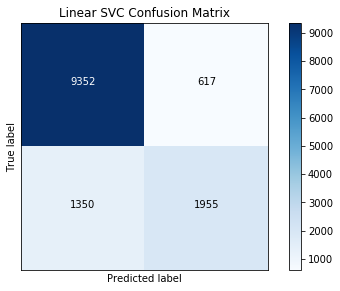

In [13]:
params_lin_svc = {'C': np.linspace(20, 50, 5000)}

lin_svc = GridSearchCV(svm.LinearSVC(), params_lin_svc, "f1", n_jobs = -1, verbose = 10)
lin_svc.fit(X_train, y_train)

plot_confusion_matrix(confusion_matrix(y_test, lin_svc.predict(X_test)), title="Linear SVC Confusion Matrix")

#### Melhor estimador

In [14]:
joblib.dump(lin_svc.best_estimator_, 'models/best_lin_svc.pkl') 
lin_svc.best_estimator_

LinearSVC(C=35.84916983396679, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)

#### Tabela de scores

In [15]:
df_scores_lin_svc = create_scores_df(lin_svc)
df_scores_lin_svc

,Accuracy Score,F1 Score,Precision Score,Recall Score
0,0.851816,0.665305,0.760109,0.591528


### SVC

#### Treino e matriz de confusão

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    9.4s
[Paralle

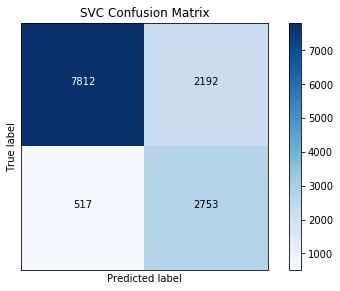

In [14]:
C_range = np.logspace(-5, 5, 10)
gamma_range = np.logspace(-5, 5, 10)

params_svc = {'C': C_range , 'gamma': gamma_range, 
              'kernel': ['linear', 'rbf']}

svc = GridSearchCV(svm.SVC(class_weight='balanced', cache_size=12000), params_svc, "f1", n_jobs = -1, verbose = 10)
svc.fit(X_train[:1000], y_train[:1000])

plot_confusion_matrix(confusion_matrix(y_test, svc.predict(X_test)), title="SVC Confusion Matrix")

c:\users\gabgo\documents\github\data-mining-w2\venv\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


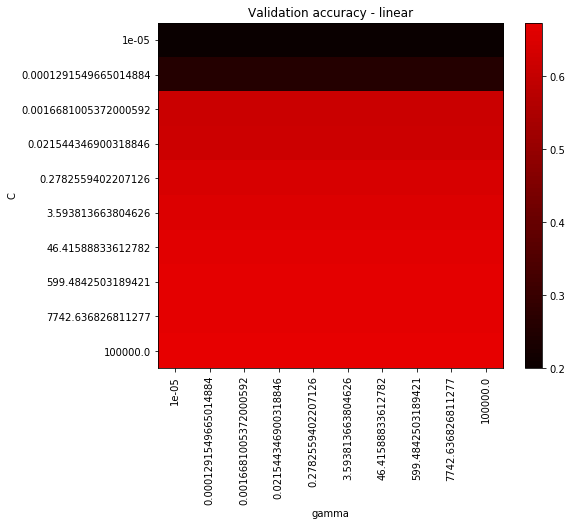

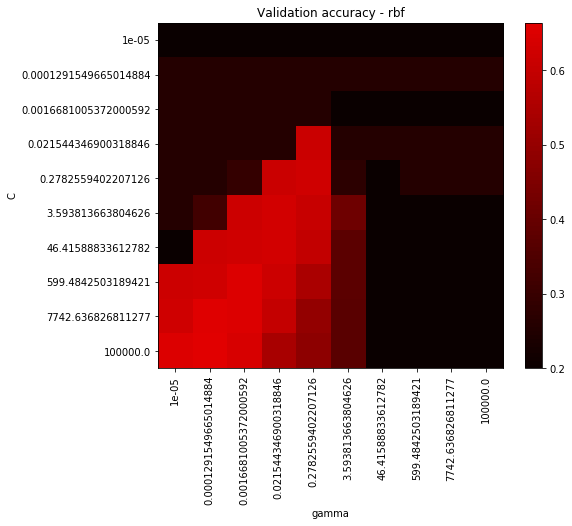

In [49]:
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
score_dict = svc.grid_scores_
i = 0
for kernel in ['linear', 'rbf']:
    scores = [x[1] for x in score_dict if x[0]['kernel'] == kernel]
    scores = np.array(scores).reshape(len(C_range), len(gamma_range))
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=90)
    plt.yticks(np.arange(len(C_range)), C_range)
    plt.title('Validation accuracy - ' + kernel)
    plt.show()

#### Melhor estimador

In [18]:
joblib.dump(svc.best_estimator_, 'models/svc_best.pkl')
svc.best_estimator_

SVC(C=100000.0, cache_size=12000, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Tabela de scores

In [19]:
df_scores_svc = create_scores_df(svc)
df_scores_svc

,Accuracy Score,F1 Score,Precision Score,Recall Score
0,0.795917,0.670237,0.556724,0.841896
